<a href="https://colab.research.google.com/github/dauparas/tensorflow_examples/blob/master/VAE_cell_cycle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/PMBio/scLVM/blob/master/tutorials/tcell_demo.ipynb

Variational Autoencoder Model (VAE) with latent subspaces based on:
https://arxiv.org/pdf/1812.06190.pdf

In [1]:
#Step 1: import dependencies
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import regularizers
import time
from __future__ import division

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

%matplotlib inline
plt.style.use('dark_background')

import pandas as pd

Using TensorFlow backend.


In [0]:
import os
from matplotlib import cm
import h5py
import scipy as SP
import pylab as PL

In [0]:
data = os.path.join('data_Tcells_normCounts.h5f')
f = h5py.File(data,'r')
Y = f['LogNcountsMmus'][:]                 # gene expression matrix
tech_noise = f['LogVar_techMmus'][:]       # technical noise
genes_het_bool=f['genes_heterogen'][:]     # index of heterogeneous genes
geneID = f['gene_names'][:]            # gene names
cellcyclegenes_filter = SP.unique(f['cellcyclegenes_filter'][:].ravel() -1) # idx of cell cycle genes from GO
cellcyclegenes_filterCB = f['ccCBall_gene_indices'][:].ravel() -1        # idx of cell cycle genes from cycle base ...

In [0]:
# filter cell cycle genes
idx_cell_cycle = SP.union1d(cellcyclegenes_filter,cellcyclegenes_filterCB)
# determine non-zero counts
idx_nonzero = SP.nonzero((Y.mean(0)**2)>0)[0]
idx_cell_cycle_noise_filtered = SP.intersect1d(idx_cell_cycle,idx_nonzero)
# subset gene expression matrix
Ycc = Y[:,idx_cell_cycle_noise_filtered]

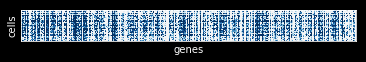

In [5]:
plt = PL.subplot(1,1,1);
PL.imshow(Ycc,cmap=cm.RdBu,vmin=-3,vmax=+3,interpolation='None');
#PL.colorbar();
plt.set_xticks([]);
plt.set_yticks([]);
PL.xlabel('genes');
PL.ylabel('cells');

In [0]:
X = np.delete(Y, idx_cell_cycle_noise_filtered, axis=1)
X = Y #base case
U = Y[:,idx_cell_cycle_noise_filtered]

mean = np.mean(X, axis=0)
variance = np.var(X, axis=0)

indx_small_mean = np.argwhere(mean < 0.00001)
X = np.delete(X, indx_small_mean, axis=1)

mean = np.mean(X, axis=0)
variance = np.var(X, axis=0)

In [123]:
fano = variance/mean

print(fano.shape)

(30233,)


In [0]:
indx_small_fano = np.argwhere(fano < 1.0)

In [0]:
X = np.delete(X, indx_small_fano, axis=1)

mean = np.mean(X, axis=0)
variance = np.var(X, axis=0)

fano = variance/mean

In [126]:
print(fano.shape)

(8892,)


In [0]:
#Reconstruction loss
def x_given_z(z, output_size):
  with tf.variable_scope('M/x_given_w_z'):
    act = tf.nn.leaky_relu
    
    h = z
    h = tf.layers.dense(h, 8, act)
    h = tf.layers.dense(h, 16, act)
    h = tf.layers.dense(h, 32, act)
    h = tf.layers.dense(h, 64, act)
    h = tf.layers.dense(h, 128, act)
    h = tf.layers.dense(h, 256, act)
    loc = tf.layers.dense(h, output_size)
    #log_variance = tf.layers.dense(x, latent_size)
    #scale = tf.nn.softplus(log_variance)
    scale = 0.01*tf.ones(tf.shape(loc))
    return tfd.MultivariateNormalDiag(loc, scale)

#KL term for z
def z_given_x(x, latent_size): #+
  with tf.variable_scope('M/z_given_x'):
    act = tf.nn.leaky_relu
    h = x
    
    h = tf.layers.dense(h, 256, act)
    h = tf.layers.dense(h, 128, act)
    h = tf.layers.dense(h, 64, act)
    h = tf.layers.dense(h, 32, act)
    h = tf.layers.dense(h, 16, act)
    h = tf.layers.dense(h, 8, act)
    
    loc = tf.layers.dense(h,latent_size)
    log_variance = tf.layers.dense(h, latent_size)
    scale = tf.nn.softplus(log_variance)
#     scale = 0.01*tf.ones(tf.shape(loc))
    return tfd.MultivariateNormalDiag(loc, scale)

def z_given(latent_size):
  with tf.variable_scope('M/z_given'):
    loc = tf.zeros(latent_size)
    scale = 0.01*tf.ones(tf.shape(loc))
    return tfd.MultivariateNormalDiag(loc, scale)

In [0]:
#Connect encoder and decoder and define the loss function
tf.reset_default_graph()

x_in = tf.placeholder(tf.float32, shape=[None, X.shape[1]], name='x_in')
x_out = tf.placeholder(tf.float32, shape=[None, X.shape[1]], name='x_out')

z_latent_size = 2

beta = 0.000001

#KL_z
zI = z_given(z_latent_size)
zIx = z_given_x(x_in, z_latent_size)
zIx_sample = zIx.sample()
zIx_mean = zIx.mean()
#kl_z = tf.reduce_mean(zIx.log_prob(zIx_sample)- zI.log_prob(zIx_sample))
kl_z = tf.reduce_mean(tfd.kl_divergence(zIx, zI)) #analytical

#Reconstruction
xIz = x_given_z(zIx_sample, X.shape[1])
rec_out = xIz.mean()
rec_loss = tf.losses.mean_squared_error(x_out, rec_out)

loss = rec_loss + beta*kl_z
optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)

In [0]:
#Helper function
def batch_generator(features, x, u, batch_size):
  """Function to create python generator to shuffle and split features into batches along the first dimension."""
  idx = np.arange(features.shape[0])
  np.random.shuffle(idx)
  for start_idx in range(0, features.shape[0], batch_size):
    end_idx = min(start_idx + batch_size, features.shape[0])
    part = idx[start_idx:end_idx]
    yield features[part,:], x[part,:] , u[part, :]

In [133]:
n_epochs = 5000
batch_size = X.shape[0]
start = time.time()
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  
  
  for i in range(n_epochs):
    gen = batch_generator(X, X, U, batch_size) #create batch generator
    rec_loss_ = 0
    kl_z_ = 0
    
    for j in range(np.int(X.shape[0]/batch_size)):
      x_in_batch, x_out_batch, u_batch = gen.__next__()
      
      
      _, rec_loss__, kl_z__= sess.run([optimizer, rec_loss, kl_z], feed_dict={x_in: x_in_batch, x_out: x_out_batch})
      rec_loss_ += rec_loss__
      kl_z_ += kl_z__
      
    if (i+1)% 50 == 0 or i == 0:
      zIx_mean_, rec_out_= sess.run([zIx_mean, rec_out], feed_dict ={x_in:X, x_out:X})
      end = time.time()
      print('epoch: {0}, rec_loss: {1:.3f}, kl_z: {2:.2f}'.format((i+1), rec_loss_/(1+np.int(X.shape[0]/batch_size)), kl_z_/(1+np.int(X.shape[0]/batch_size))))
      start = time.time()

epoch: 1, rec_loss: 0.488, kl_z: 5038.03
epoch: 50, rec_loss: 0.256, kl_z: 1169.19
epoch: 100, rec_loss: 0.254, kl_z: 1150.47
epoch: 150, rec_loss: 0.256, kl_z: 1138.06
epoch: 200, rec_loss: 0.253, kl_z: 891.83
epoch: 250, rec_loss: 0.250, kl_z: 493.30
epoch: 300, rec_loss: 0.248, kl_z: 730.26
epoch: 350, rec_loss: 0.243, kl_z: 559.81
epoch: 400, rec_loss: 0.238, kl_z: 564.55
epoch: 450, rec_loss: 0.234, kl_z: 710.93
epoch: 500, rec_loss: 0.228, kl_z: 784.23
epoch: 550, rec_loss: 0.222, kl_z: 896.33
epoch: 600, rec_loss: 0.217, kl_z: 1257.52
epoch: 650, rec_loss: 0.208, kl_z: 1527.80
epoch: 700, rec_loss: 0.195, kl_z: 1799.51
epoch: 750, rec_loss: 0.185, kl_z: 2238.79
epoch: 800, rec_loss: 0.169, kl_z: 2253.14
epoch: 850, rec_loss: 0.163, kl_z: 2524.81
epoch: 900, rec_loss: 0.153, kl_z: 2371.30
epoch: 950, rec_loss: 0.138, kl_z: 2567.25
epoch: 1000, rec_loss: 0.129, kl_z: 2703.91
epoch: 1050, rec_loss: 0.119, kl_z: 2730.01
epoch: 1100, rec_loss: 0.110, kl_z: 2854.48
epoch: 1150, rec_lo

In [134]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
svd.fit(U.T)  


print(svd.explained_variance_ratio_)  

print(svd.explained_variance_ratio_.sum())  

print(svd.singular_values_)  

U_ = svd.components_

U_ = U_.T

[0.55983905 0.04389005]
0.6037290921647739
[482.32958745  71.86901165]


In [0]:
import matplotlib.pyplot as plt

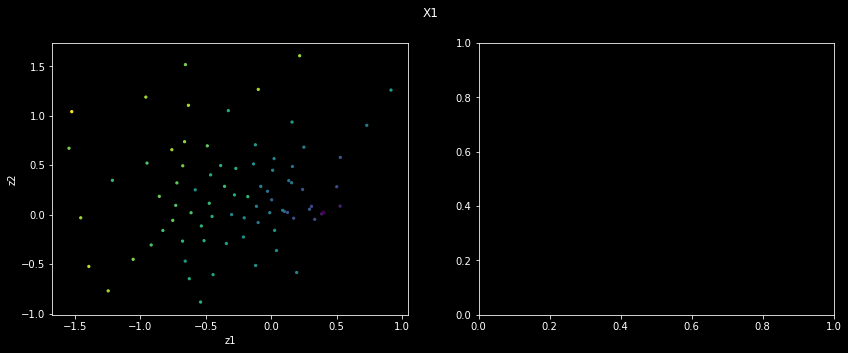

In [136]:
fig, axs = plt.subplots(1, 2, figsize=(14,5))
axs[0].scatter(zIx_mean_[:,0],zIx_mean_[:,1], c=U_[:,0], cmap='viridis', s=5.0);
axs[0].set_xlabel('z1')
axs[0].set_ylabel('z2')

fig.suptitle('X1')
plt.show()

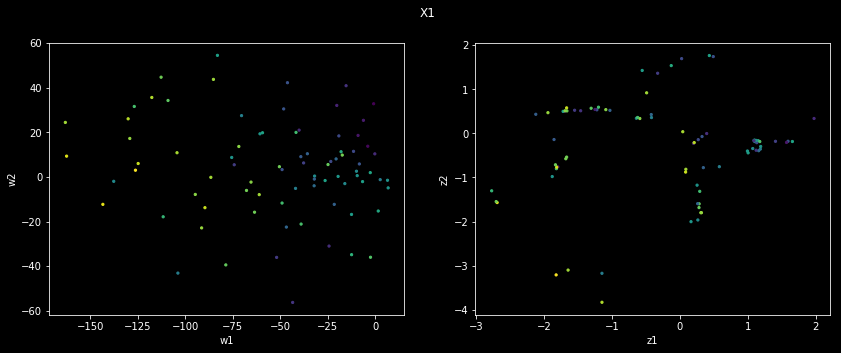

In [0]:
fig, axs = plt.subplots(1, 2, figsize=(14,5))
axs[0].scatter(wIxy_mean_[:,0],wIxy_mean_[:,1], c=U_[:,1], cmap='viridis', s=5.0);
axs[0].set_xlabel('w1')
axs[0].set_ylabel('w2')

axs[1].scatter(zIx_mean_[:,0],zIx_mean_[:,1], c=U_[:,1], cmap='viridis', s=5.0);
axs[1].set_xlabel('z1')
axs[1].set_ylabel('z2')

fig.suptitle('X1')
plt.show()

In [0]:
error = np.abs(X-rec_out_)

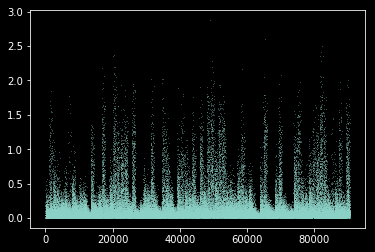

In [0]:
plt.plot(np.reshape(error, -1), '*', markersize=0.1);

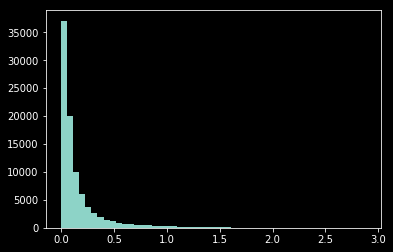

In [0]:
plt.hist(np.reshape(error, -1), bins=50);